# **Tranfer Learning sur la base de donnée euroSAT**

- [Article de référence](https://arxiv.org/pdf/1709.00029.pdf)
- [Base de donnée euroSAT](http://madm.dfki.de/downloads) *(version RGB)*
- [Article Medium utilisé](https://medium.com/omdena/fighting-hunger-through-open-satellite-data-a-new-state-of-the-art-for-land-use-classification-f57f20b7294b)

In [1]:
import os
import time
import copy

import tensorflow as tf
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1050 Ti


### **Partie DataLoader**

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
    ]),
}

data_dir = '../euroSAT_dataset'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

In [6]:
all_images = torch.zeros((dataset_sizes['train'], 3, 64, 64))
for i in np.arange(dataset_sizes['train']):
    all_images[i] = image_datasets['train'][i][0]

In [7]:
stat_mean = all_images.mean(-1).mean(-1).mean(0)
stat_std = all_images.std(-1).std(-1).std(0)

stat_mean.tolist(), stat_std.tolist()

print('Moyenne des pixels pour\n\n- Red : {0}\n- Green : {1}\n- Blue : {2}'.format(
        stat_mean[0],
        stat_mean[1],
        stat_mean[2]))

print('\nEcart-type des pixels pour\n\n- Red : {0}\n- Green : {1}\n- Blue : {2}'.format(
        stat_std[0],
        stat_std[1],
        stat_std[2]))

Moyenne des pixels pour

- Red : 0.3435135781764984
- Green : 0.37966683506965637
- Blue : 0.40722525119781494

Ecart-type des pixels pour

- Red : 0.018772099167108536
- Green : 0.014673473313450813
- Blue : 0.01349729299545288


*'For models trained on images centered using these means that may be used for transfer learning on new tasks, it can be beneficial or even required to normalize images for the new task using the same means.'*  
[source](https://machinelearningmastery.com/how-to-manually-scale-image-pixel-data-for-deep-learning/)  
  
On prend donc au final le vecteur de moyen et de variance [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

In [17]:
data_transforms_norm = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(224),
        #transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        #transforms.Resize(224),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

data_dir = '../euroSAT_dataset'

image_datasets_norm = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                               data_transforms_norm[x])
                       for x in ['train', 'test']}

dataloaders_norm = {x: torch.utils.data.DataLoader(image_datasets_norm[x], batch_size=256,
                                                   shuffle=True, num_workers=4)
                    for x in ['train', 'test']}

dataset_sizes = {x: len(image_datasets_norm[x]) for x in ['train', 'test']}
class_names_norm = image_datasets_norm['train'].classes

### **Affichage d'une image**

Images avant normalisation



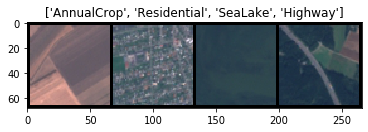

In [11]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
print("Images avant normalisation\n")

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Images après normalisation



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


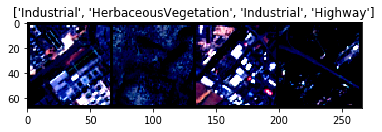

In [15]:
print("Images après normalisation\n")

# Get a batch of training data
inputs, classes = next(iter(dataloaders_norm['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Images après dénormalisation



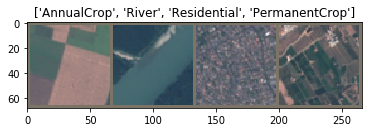

In [16]:
def imshow_denormalized(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1) # renvoi les valeurs dans l'intervalle [0, 1]
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
print("Images après dénormalisation\n")

# Get a batch of training data3.94
inputs, classes = next(iter(dataloaders_norm['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow_denormalized(out, title=[class_names[x] for x in classes])

### Mise en place du modèle ResNet50

In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders_norm[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [19]:
model_ft = models.resnet50(pretrained=True, progress=True)


In [20]:
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters())
# model_ft.fc.parameters()

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=4, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=24)

`batch_size=4` + `num_workers=4` / `optim.Adam` / `CrossEntropyLoss`  
- Training complete in 11m 18s
- Best test Acc: 0.726649  

`batch_size=8` + `num_workers=8` / `optim.Adam` / `CrossEntropyLoss` 
- Training complete in 6m 16s
- Best test Acc: 0.777613

`batch_size=64` + `num_workers=64` / `optim.Adam` / `CrossEntropyLoss` 
- Training complete in 2m 40s
- Best test Acc: 0.932357

`batch_size=64` + `num_workers=4` / `optim.Adam` / `CrossEntropyLoss` 
- Training complete in 2m 25s
- Best test Acc: 0.937176

`batch_size=256` + `num_workers=4` / `optim.Adam` / `CrossEntropyLoss` 
- Training complete in 1m 59s
- Best test Acc: 0.906412

`batch_size=256` + `num_workers=4` / `optim.Adam` / `CrossEntropyLoss` / `num_epochs=24`  
- Training complete in 23m 48s
- Best test Acc: 0.984062

### **Sauvegarde du modèle au format `state_dict` (recommandé)**
[source](https://pytorch.org/tutorials/beginner/saving_loading_models.html#save-load-state-dict-recommended)

In [26]:
os.makedirs(os.path.join(data_dir, 'models'), exist_ok=True)

In [27]:
# Sauvegarde
torch.save(model_ft.state_dict(), os.path.join(data_dir, 'models/euroSAT_model_98_stat_dict.pt'))

In [21]:
# Chargement
model_load = models.resnet50(pretrained=False, progress=True)
num_ftrs = model_load.fc.in_features
model_load.fc = nn.Linear(num_ftrs, 10)

model_load.load_state_dict(torch.load(os.path.join(data_dir, 'models/euroSAT_model_98_stat_dict.pt'))) # On charge un state_dict et pas directement le fichier (path)
model_load.eval() # set dropout and batch normalization layers to evaluation

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### **Sauvegarde du modèle entier (plus simple)**
[source](https://pytorch.org/tutorials/beginner/saving_loading_models.html#save-load-entire-model)

In [28]:
# Sauvegarde
torch.save(model_ft, os.path.join(data_dir, 'models/euroSAT_model_98_entier.pt'))

In [30]:
# Chargement
model_load_entier = torch.load(os.path.join(data_dir, 'models/euroSAT_model_98_entier.pt')) # Model class must be defined somewhere
model_load_entier.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 